In [2]:
from PIL import Image
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt
from normxcorr2 import normxcorr2
import statistics 
import math


In [3]:
#define find offset function for beads file
def find_offset(path):
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
        beads = np.array(images)
    beadsavg=np.mean(beads, axis=0)
    #initialize offsets; cut the edge for donor(20) and acceptor(10) channels
    offsetx = 0
    offsety = 0
    donor = beadsavg[(20):int(beadsavg.shape[0]-20),(20):int(beadsavg.shape[1]/2-20)]
    acceptor = beadsavg[10:int(beadsavg.shape[0]-10),int(beadsavg.shape[1]/2+10):int(beadsavg.shape[1]-10)]
    #find cross correlation array, size should be D+A-1
    cc = normxcorr2(donor,acceptor)
    #output the offset values, since we expect donor locate in tbe middle of acceptor, so -10; +1 since python starts at 0
    offsetx = np.where(cc==np.max(cc))[1][0]-donor.shape[1]-10+1
    offsety = np.where(cc==np.max(cc))[0][0]-donor.shape[0]-10+1
    return print('x offset = '+str(offsetx)+' and y offset = '+str(offsety))

In [5]:
find_offset('PSD78/PSD78-beads/beads_200703.tif')

x offset = -7 and y offset = 3


#input data file path
path = '...'
#input offsets that output from find_offsets
offsetx = -7
offsety = 3
#input frame squence
firstred = 10
green = 500
#other parameters
neighborhood_size = 5 #find local maxima within this range of radius
threshold = 200 #intensity threshold
edgecut = 9 #exclude pixels this far away from the edge in each channel
check_green = 10 #how many green frames used to find matching in D/A channels
min_distance = 5 #minimum distance for molecules considered as separate ones, i.e. not aggregating

In [6]:
def read_tiff(path):
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
        data = np.array(images)
    return data

In [7]:
data = read_tiff('PSD78/200703/encapPSD78.tif')

In [8]:
data.shape

(560, 512, 512)

In [9]:
def bg_subtraction(firstred, green, data):
    
    #getting mean values for all 500 green frames & last 50 red frames for background subtraction 
    greendata = data[firstred:firstred+green,:,:]
    reddata = data[firstred+green:,:,:]
    green_avg = np.mean(greendata, axis = 0).flatten()
    red_avg = np.mean(reddata, axis = 0).flatten()
    
    #getting mean for each channel individually 
    green_d = np.mean(greendata[:,:,:256], axis = 0).flatten()
    green_a = np.mean(greendata[:,:,256:], axis = 0).flatten()
    red_d = np.mean(reddata[:,:,:256], axis = 0).flatten()
    red_a = np.mean(reddata[:,:,256:], axis = 0).flatten()
    
    #locate the bin that has the most counts, since in each frame background pixels are the mojority 
    counts_g, bins_g = np.histogram(green_avg, bins=100)
    bg_threshold_g = math.ceil(bins_g[(np.where(counts_g==np.max(counts_g))[0][0]+1)])
    counts_r, bins_r = np.histogram(red_avg, bins=100)
    bg_threshold_r = math.ceil(bins_r[(np.where(counts_r==np.max(counts_r))[0][0]+1)]) #plus one bin to include outliers
    bg_threshold_g, bg_threshold_r #below these value considered as bg pixels
    
    #background values for green & red excitation frams in both D/A channels
    greenbg_d = statistics.median(green_d[np.where(green_d<bg_threshold_g)])
    greenbg_a = statistics.median(green_a[np.where(green_a<bg_threshold_g)])
    redbg_d = statistics.median(red_d[np.where(red_d<bg_threshold_r)])
    redbg_a = statistics.median(red_a[np.where(red_a<bg_threshold_r)])
    

    #bg-subtraction
    r1_a = data[:firstred,:,256:512]-redbg_a
    g_a = data[firstred:firstred+green,:,256:512]-greenbg_a
    r2_a = data[firstred+green:,:,256:512]-redbg_a
    r1_d = data[:firstred,:,0:256]-redbg_d
    g_d = data[firstred:firstred+green,:,:256]-greenbg_d
    r2_d = data[firstred+green:,:,:256]-redbg_d
    
    acceptor = np.vstack((r1_a, g_a, r2_a))
    donor = np.vstack((r1_d, g_d, r2_d))
    data = np.dstack((donor,acceptor))
    
    return data
    

In [10]:
data = bg_subtraction(10,500,data)

In [12]:
data

array([[[-27.74, -16.74, -23.74, ..., -18.  , -33.  , -41.  ],
        [-14.74,  -5.74, -18.74, ..., -38.  , -37.  , -18.  ],
        [-11.74, -17.74,  -9.74, ...,   5.  ,  56.  , -12.  ],
        ...,
        [-15.74,  59.26,  -9.74, ..., -15.  , -28.  , -28.  ],
        [-12.74, -10.74, -13.74, ..., -29.  , -31.  , -25.  ],
        [-11.74, -14.74, -13.74, ..., -27.  , -26.  , -26.  ]],

       [[-17.74, -25.74, -22.74, ..., -23.  , -19.  , -41.  ],
        [-16.74, -20.74, -14.74, ...,  90.  , -44.  , -33.  ],
        [-12.74, -12.74, -26.74, ..., -44.  ,  11.  , -34.  ],
        ...,
        [-11.74,   1.26,  -8.74, ..., -34.  , -25.  , -35.  ],
        [-12.74, -11.74,  -9.74, ..., -34.  , -11.  , -32.  ],
        [-14.74, -10.74, -13.74, ..., -25.  , -33.  , -25.  ]],

       [[-13.74, -20.74, -13.74, ..., -33.  , -29.  , -41.  ],
        [-21.74, -19.74, -20.74, ..., -45.  , -38.  , -35.  ],
        [-19.74, -17.74, -18.74, ..., -30.  , -20.  , -31.  ],
        ...,
        [-12

In [7]:
#define molecule extraction function for data file
def locate_molecules(offsetx, offsety, firstred, green, neighborhood_size, threshold, edgecut, check_green, min_distance):
    
    #getting molecule positions map frame by frame
    maxima = []
    maximamap = np.zeros((560,512,512)) #local brightest pixel map for each frames
    for i in range(data.shape[0]):
        data_max = filters.maximum_filter(data[i,:,:], neighborhood_size) #local maximum filter
        maxima = (data[i,:,:] == data_max) #extract local brightest pixels w/ True to be the local brightest pixel
        data_min = filters.minimum_filter(data[i,:,:], neighborhood_size) #local minimum filter
        diff = ((data_max - data_min) > threshold) #extract pixels w/ intensity above threshold
        maxima[diff == 0] = 0
        maximamap[i,:,:] = maxima
    first_acceptormap = maximamap[0:firstred,:,256:512]
    fret_donormap = maximamap[firstred:green+firstred,:,0:256]
    fret_acceptormap = maximamap[firstred:green+firstred,:,256:512] #split D/A sides to make D/A map 
    
    #cut the edge by "edgecut" pixels and match D/A channel
    fret_molecules_cut = ((fret_acceptormap[0:check_green,edgecut:(fret_acceptormap.shape[1]-edgecut),edgecut:(fret_acceptormap.shape[2]-edgecut)] == 1)\
                          & \
                         (fret_acceptormap[0:check_green,edgecut:(fret_acceptormap.shape[1]-edgecut),edgecut:(fret_acceptormap.shape[2]-edgecut)] == \
                         fret_donormap[0:check_green,(edgecut-offsety):(fret_donormap.shape[1]-edgecut-offsety),(edgecut-offsetx):(fret_donormap.shape[2]-edgecut-offsetx)]))
    fret_molecules = np.zeros((check_green,512,256)) #detected matching molecules map for each frame
    fret_molecules[:,edgecut:(fret_molecules.shape[1]-edgecut),edgecut:(fret_molecules.shape[2]-edgecut)] = fret_molecules_cut
    fret_molecules_map = (np.mean(fret_molecules, axis=0)!=0) #with value not equal to zero means at least match in one frame, cords are in A channel 
    
    #exclude aggregations
    molecule_coords = np.argwhere(fret_molecules_map == 1) #extract matching molecules coords
    y_coord=molecule_coords[:,0] 
    x_coord=molecule_coords[:,1] 
    xx=np.tile(x_coord,(len(x_coord),1)) #duplicate x coords by molecule number of rows
    yy=np.tile(y_coord,(len(y_coord),1)) #duplicate y coords by molecule number of rows
    xx_t=np.transpose(xx) #duplicate x coords by the molecule number of columns
    yy_t=np.transpose(yy) #duplicate y coords by the molecule number of columns
    distance=(yy-yy_t)**2+(xx-xx_t)**2 #distance^2 array, symmetric, diagnal elements are 0
    overlap=np.argwhere((distance<min_distance**2) & (distance>0)).flatten() #compare with min_distance^2, smaller means aggregation; get aggregation column/row indices 
    overlap_n=np.array(list(set(overlap))) #finalize the aggregation molecules column/row indices(numbers)
    final_coords=np.delete(molecule_coords,overlap_n,0) #delete aggregation molecules 
    
    
    return [print('found this many molecules:' + str(final_coords.shape[0])), final_coords]
    

In [9]:
final_coords = locate_molecules(-7,3,10,500,5,200,9,10,5)[1]

found this many molecules:423


In [492]:
final_coords.shape

(226, 2)

In [493]:
offsetx = -7
offsety = 3
final_molecules_map = np.zeros((512,256)) 
final_molecules_map[final_coords[:,0],final_coords[:,1]] = 1 #final map in A channel with aggregation removing
donor_molecules_map = np.zeros((512,256))
donor_molecules_map[final_coords[:,0]-offsety,final_coords[:,1]-offsetx] = 1 #final map in D channel with aggregation removing

In [494]:
#splitting data to D/A channels
acceptor = data[:,:,256:512]
donor = data[:,:,0:256]

#move final_molecules_map around to expand the molecule area (assume single molecule may occupy 3*3 square pixels)
lmap = np.zeros((512,256))
rmap = np.zeros((512,256))
tmap = np.zeros((512,256))
bmap = np.zeros((512,256))
tlmap = np.zeros((512,256))
trmap = np.zeros((512,256))
blmap = np.zeros((512,256))
brmap = np.zeros((512,256))

lmap[:,0:-1] = final_molecules_map[:,1:] 
rmap[:,1:] = final_molecules_map[:,0:-1]
tmap[0:-1,:] = final_molecules_map[1:,:]
bmap[1:,:] = final_molecules_map[0:-1,:]
tlmap[0:-1,0:-1] = final_molecules_map[1:,1:]
trmap[0:-1,1:] = final_molecules_map[1:,0:-1]
blmap[1:,0:-1] = final_molecules_map[0:-1,1:]
brmap[1:,1:] = final_molecules_map[0:-1:,0:-1] 

#intensity_map=lmap+rmap+tmap+bmap+tlmap+trmap+blmap+brmap+final_molecules_map
#intensity_map[np.newaxis,:,:]

#take out the molecule region elements from raw data
l_A = acceptor[np.tile(lmap.astype('bool'),(560,1,1))].reshape((560,-1))
r_A = acceptor[np.tile(rmap.astype('bool'),(560,1,1))].reshape((560,-1))
t_A = acceptor[np.tile(tmap.astype('bool'),(560,1,1))].reshape((560,-1))
b_A = acceptor[np.tile(bmap.astype('bool'),(560,1,1))].reshape((560,-1))
tl_A = acceptor[np.tile(tlmap.astype('bool'),(560,1,1))].reshape((560,-1))
tr_A = acceptor[np.tile(trmap.astype('bool'),(560,1,1))].reshape((560,-1))
bl_A = acceptor[np.tile(blmap.astype('bool'),(560,1,1))].reshape((560,-1))
br_A = acceptor[np.tile(brmap.astype('bool'),(560,1,1))].reshape((560,-1))
c_A = acceptor[np.tile(final_molecules_map.astype('bool'),(560,1,1))].reshape((560,-1))

mole_area_A = np.array([l_A, r_A, t_A, b_A, tl_A, tr_A, bl_A, br_A, c_A])
intensity_order_A = np.sort(mole_area_A,axis=0)
intensity_A = sum(intensity_order_A[-4:,:,:])

In [495]:
intensity_A.shape

(560, 226)

In [496]:
#same for donor
lmap_D = np.zeros((512,256))
rmap_D = np.zeros((512,256))
tmap_D = np.zeros((512,256))
bmap_D = np.zeros((512,256))
tlmap_D = np.zeros((512,256))
trmap_D = np.zeros((512,256))
blmap_D = np.zeros((512,256))
brmap_D = np.zeros((512,256))

lmap_D[:,0:-1] = donor_molecules_map[:,1:] 
rmap_D[:,1:] = donor_molecules_map[:,0:-1]
tmap_D[0:-1,:] = donor_molecules_map[1:,:]
bmap_D[1:,:] = donor_molecules_map[0:-1,:]
tlmap_D[0:-1,0:-1] = donor_molecules_map[1:,1:]
trmap_D[0:-1,1:] = donor_molecules_map[1:,0:-1]
blmap_D[1:,0:-1] = donor_molecules_map[0:-1,1:]
brmap_D[1:,1:] = donor_molecules_map[0:-1:,0:-1] 

l_D = donor[np.tile(lmap_D.astype('bool'),(560,1,1))].reshape((560,-1))
r_D = donor[np.tile(rmap_D.astype('bool'),(560,1,1))].reshape((560,-1))
t_D = donor[np.tile(tmap_D.astype('bool'),(560,1,1))].reshape((560,-1))
b_D = donor[np.tile(bmap_D.astype('bool'),(560,1,1))].reshape((560,-1))
tl_D = donor[np.tile(tlmap_D.astype('bool'),(560,1,1))].reshape((560,-1))
tr_D = donor[np.tile(trmap_D.astype('bool'),(560,1,1))].reshape((560,-1))
bl_D = donor[np.tile(blmap_D.astype('bool'),(560,1,1))].reshape((560,-1))
br_D = donor[np.tile(brmap_D.astype('bool'),(560,1,1))].reshape((560,-1))
c_D = donor[np.tile(donor_molecules_map.astype('bool'),(560,1,1))].reshape((560,-1))

mole_area_D = np.array([l_D, r_D, t_D, b_D, tl_D, tr_D, bl_D, br_D, c_D])
intensity_order_D = np.sort(mole_area_D,axis=0)
intensity_D = sum(intensity_order_D[-4:,:,:])


In [497]:
intensity_D.shape

(560, 226)

In [498]:
# merge D/A intensity in to one 2D array, 560*2(num. molecules), formatted as unstacked data from ebFRET
intensity_DA = np.stack((intensity_D, intensity_A),axis=2).reshape((560,-1))
np.savetxt('traces01_2.dat', intensity_DA, fmt='%8.1f')


In [499]:
intensity_DA.shape

(560, 452)

## Pruning Traces

In [116]:
#Pruning Traces:
# Selecting single molecules.  
# Using TraceView.m in MATLAB to run through *.traces files output from GUI movie analysis
# Is A647 present and level stable during first red phase?
# 	•	If NO then END
# Is A555 present during start of green phase?
# 	•	If NO then END
# 	•	If YES then 3
# Does A555 appear as single dye (i.e. stable levels in absence of FRET, bleach or blink to baseline)
# 	•	If NO then END
# 	•	If YES then 4
# Is A647 present during green phase 
# 	•	If NO then end
# 	•	If YES then 5
# Does A647 appear as single dye (i.e. stable levels in absence of FRET, bleach or blink to baseline)
# 	•	If NO then END
# 	•	If YES then 6
# Are there anti-correlated changes in intensity (e.g. A555 goes up when A647 bleach)
# 	•	If NO or uncorrelated changes then end
# 	•	If yes then SAVE
# Is there any evidence that these are single dyes (e.g. blink or bleach to baseline. No integer multiples of the intensity)
# 	•	If NO then END
# 	•	If YES then SAVE


In [1]:
def corrcoeff(D, A, framenumber):
    rho = np.corrcoef(D[10:framenumber],A[10:framenumber])
    rho = rho[0,1]
    return rho

In [10]:
intensity_DA = np.loadtxt('traces01_5_good.dat')
intensity_DA.shape

(560, 30)

In [11]:
#from 1 column, pick every other column: data[:,451] == data[:,1::2][:,225]
A = intensity_DA[:,1::2]
D = intensity_DA[:,::2]
fret_A = A[10:510,:]
fret_D = D[10:510,:]
E_fret = A/(A+D)
E_fret.shape
loops = E_fret.shape[1]

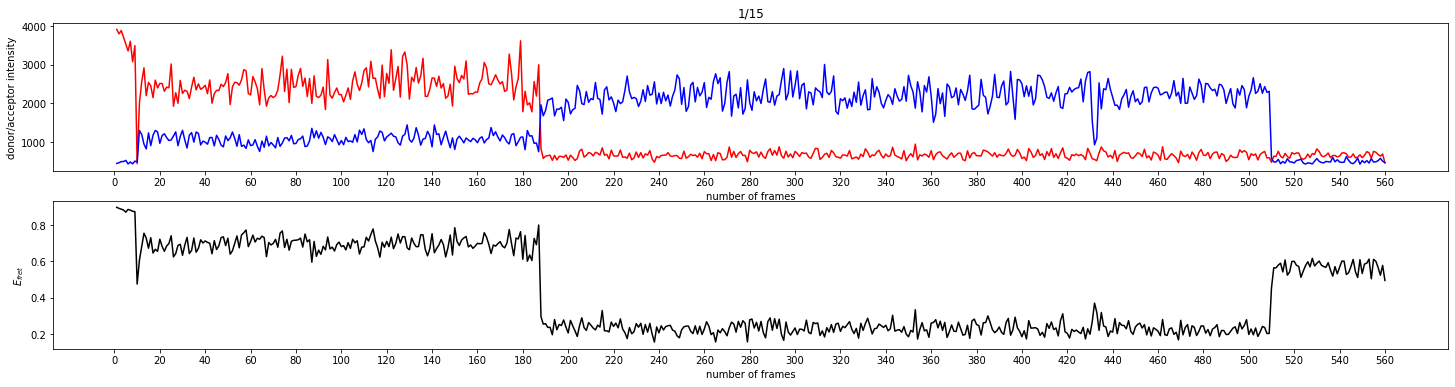

Save or not?s
At which frame the acceptor is bleached?188


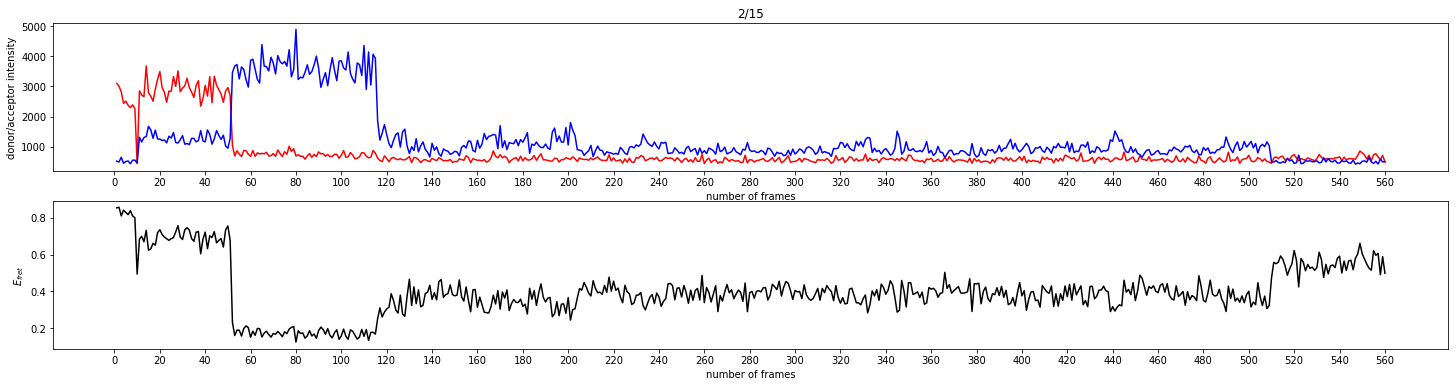

KeyboardInterrupt: Interrupted by user

In [12]:
# check all molecules with the criteria 1 & 2
# criteria 3, 4, 5 by eye
coefficient = np.zeros(loops)
pw_fret = []
saved_traces = []
for i in range(loops):
    if np.mean(A[:9,i])>1000 and np.std(A[:9,i])<0.15*np.mean(A[:9,i]):   #first red phase 10 frames average intensity > 1000, and std < 15%*mean, consider 647 present and stable
        if np.mean(D[10:13,i])>1000:  #first 3 frames green phase average intensity > 500, consider 555 present
            plt.figure(figsize=(25,6))
            ax1 = plt.subplot(211)
            plt.plot(np.linspace(1,560,560),A[:,i],'r')
            plt.plot(np.linspace(1,560,560),D[:,i],'b')
            plt.xlabel('number of frames')
            plt.ylabel('donor/acceptor intensity')
            plt.xticks(np.arange(0, 561, 20))
            plt.title(str(i+1)+'/'+str(loops))
            ax2 = plt.subplot(212)
            plt.plot(np.linspace(1,560,560),E_fret[:,i],'k')
            plt.xlabel('number of frames')
            plt.ylabel('$E_{fret}$')
            plt.xticks(np.arange(0, 561, 20))
            plt.show()
            save = input("Save or not?")
            if str(save)=='s':
                framenumber = int(input("At which frame the acceptor is bleached?"))
                #coefficient[i] = corrcoeff(D[:,i],A[:,i],framenumber)
                pw_fret.append(E_fret[10:framenumber,i])
                saved_traces.append(D[:,i])
                saved_traces.append(A[:,i])
                #plt.clf()
#             elif str(save)=='b':
#                 i = i-5
#                 continue
            else:
                #plt.clf()
                continue
                    

In [109]:
for i in range(len(pw_fret)):
    print(pw_fret[i].shape)

(346,)
(53,)
(223,)
(17,)
(60,)
(151,)
(178,)
(165,)
(27,)
(366,)
(53,)
(30,)
(48,)
(32,)
(15,)


In [110]:
#save coeff. & pw_E results
coefficient_s = coefficient[np.argwhere(coefficient!=0)].ravel()
coefficient_s = coefficient_s[~np.isnan(coefficient_s)] #in case saved a bad one and entered 0 for bleaching frames
pw_E = np.concatenate(pw_fret)
np.savetxt('traces07_5_coeff.dat', coefficient_s, fmt='%7.5f')
np.savetxt('traces07_5_pwE.dat', pw_E, fmt='%7.5f')
traces_s = np.array(saved_traces).transpose()
np.savetxt('traces07_5_good.dat', traces_s, fmt='%8.1f')